In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/data_pill"))

['original', 'segmented']


In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_dir = "/content/drive/MyDrive/data_pill"
seg_dir =  "/content/drive/MyDrive/data_pill/segmented"
img_dir =  "/content/drive/MyDrive/data_pill/original"
seg_files = np.array(seg_dir)
seg_files = np.array(os.listdir(seg_dir))
#check the first file
first_file = seg_files[0]
print(first_file)

pill_ginseng_contamination_092.png


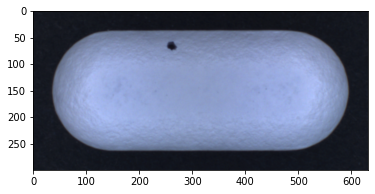

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
seg = load_img(seg_dir + "/" + first_file)
img = load_img(img_dir + "/" + first_file)
plt.imshow(img)

In [ ]:
print("img_shape = ", img_to_array(img).shape)

img_shape =  (300, 632, 3)


In [ ]:
# n_classes = int(np.max(seg)+1)
n_classes=3
print("There are {} labels".format(n_classes))

There are 3 labels


In [ ]:
#show the ground_truth 
def design_colormap(seg, n_classes):
    """
    seg: (width, height)
    return: (width, height,3)
    """
    seg_img = np.zeros(seg.shape+(3,)).astype("float")
    colors = sns.color_palette("hls", 12)
    
    for label in np.arange(n_classes):
        segc = (seg == label)
        segc = segc.astype("int")
        for channel in range(3):
            seg_img[:, :, channel] += segc*(colors[label][channel])
    return seg_img



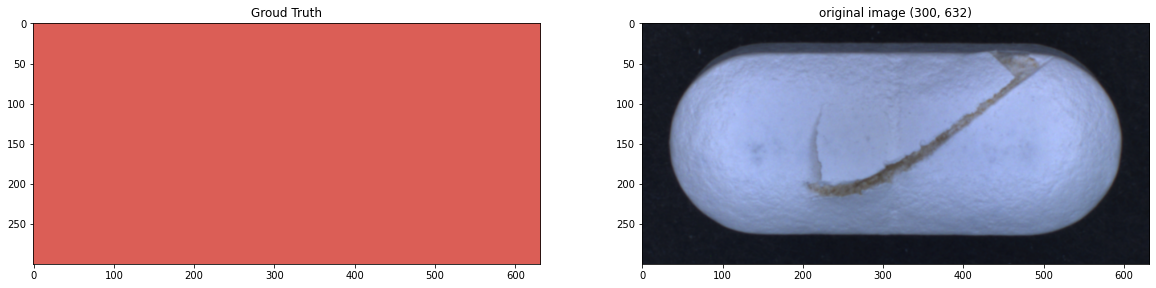

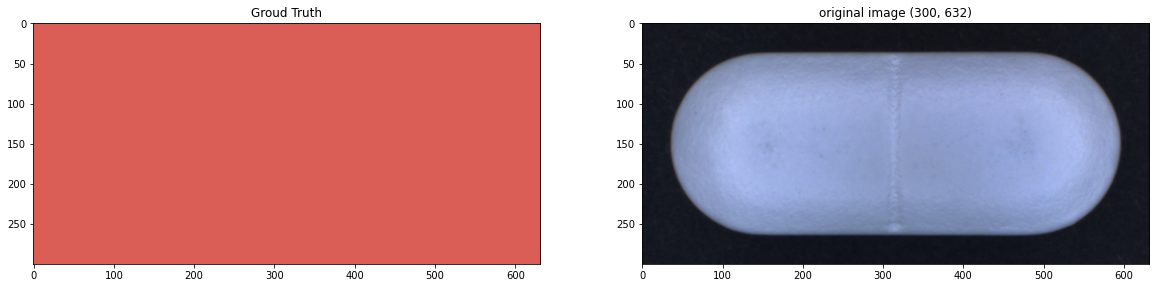

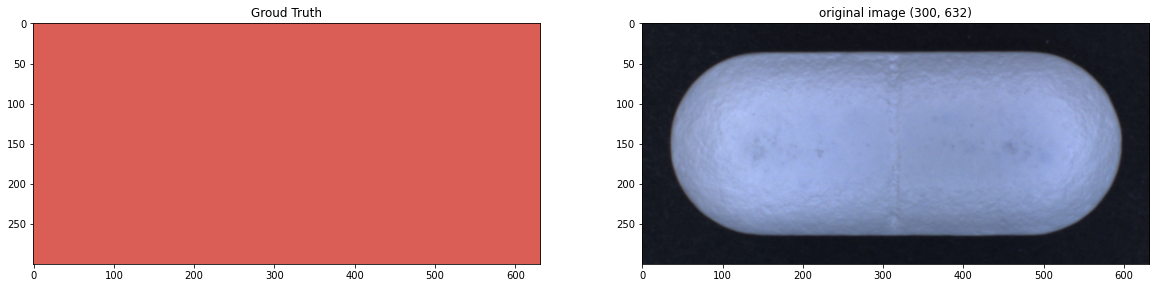

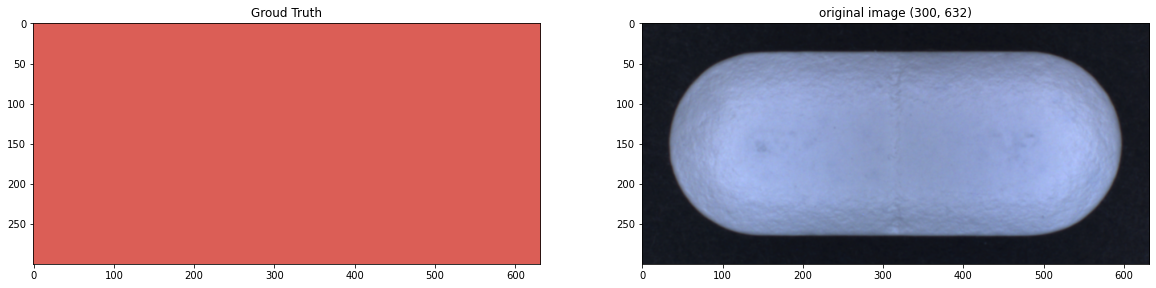

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img


for fnm in seg_files[np.random.choice(len(seg_files),4,replace=False)]:
    seg = load_img(seg_dir + "/" + fnm) # (360, 700, 3)
    seg = img_to_array(seg)
    seg_img = design_colormap(seg[:,:,0],n_classes)
    img = load_img(img_dir + "/" + fnm)
    img = img_to_array(img)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,2,1)
    ax.imshow(seg_img)
    ax.set_title("Groud Truth")
    
    ax = fig.add_subplot(1,2,2)
    ax.imshow(img/255.0)
    ax.set_title("original image {}".format(img.shape[:2]))

In [ ]:
import cv2
#resize images to (224,224) for VGG
input_height , input_width = 512 , 512
output_height , output_width = 512 , 512

def getSegmentationArr(path, n_classes,width, height):
    seg_labels = np.zeros((height, width, n_classes))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height))
    img = img[:, : , 0]

    for c in range(n_classes):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

images = np.array(os.listdir(img_dir))
images.sort()
segmentations  = os.listdir(seg_dir)
segmentations.sort()
    
X = []
Y = []
for im, seg in zip(images,segmentations):
    img = cv2.imread(img_dir + '/'+  im, 1)
    img = cv2.resize(img, (input_width , input_height ))
    img = img_to_array(img)
    X.append(img)
    Y.append(getSegmentationArr( seg_dir + '/'+ seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
X = X/255.0
print(X.shape,Y.shape)

(592, 512, 512, 3) (592, 512, 512, 3)


In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

In [ ]:
tf.keras.layers.Conv2DTranspose

keras.layers.convolutional.conv2d_transpose.Conv2DTranspose

In [ ]:
# Function to create to a series of CONV layers followed by Max pooling layer
def Convblock(channel_dimension, block_no, no_of_convs) :
    Layers = []
    for i in range(no_of_convs) :
        
        Conv_name = "conv"+str(block_no)+"_"+str(i+1)
        
        # A constant kernel size of 3*3 is used for all convolutions
        Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))
    
    Max_pooling_name = "pool"+str(block_no)
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))
    
    return Layers

In [ ]:
from keras.layers.convolutional import Deconvolution2D
#Helper function to create Sequential part of the Architecture
def FCN_16_helper(image_size):
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (image_size,image_size,3)))
    
    
    for l in Convblock(64,1,2) :
        model.add(l)
    
    for l in Convblock(128,2,2):
        model.add(l)
    
    for l in Convblock(256,3,3):
        model.add(l)
    
    for l in Convblock(512,4,3):
        model.add(l)
    
    for l in Convblock(512,5,3):
        model.add(l)
    
    
    model.add(Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc_6"))
    
    #Replacing fully connnected layers of VGG Net using convolutions
    model.add(Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))
     # Gives the classifications scores for each of the 21 classes including background
    model.add(Convolution2D(3,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))
    
    
    Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
    print(Conv_size)
    
    model.add(Deconvolution2D(3,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))
    
    # O = ((I-K+2*P)/Stride)+1 
    # O = Output dimesnion after convolution
    # I = Input dimnesion
    # K = kernel Size
    # P = Padding
    
    # I = (O-1)*Stride + K 
    Deconv_size = model.layers[-1].output_shape[2] #34 if image size is 512*512
    
    print(Deconv_size)
    # 2 if image size is 512*512
    Extra = (Deconv_size - 2*Conv_size)
    
    print(Extra)
    
    #Cropping to get correct size
    model.add(Cropping2D(cropping=((0,Extra),(0,Extra))))
    return model

output = FCN_16_helper(512)
print(len(output.layers))
print(output.layers[14])
print (output.summary())

ImportError: ignored

In [ ]:
def FCN_16(image_size) :
    fcn_16 = FCN_16_helper(512)
    
    #Calculating conv size after the sequential block
    #32 if image size is 512*512
    Conv_size = fcn_16.layers[-1].output_shape[2] 
    
    skip_con = Convolution2D(3,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")
    
    #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
    Summed = add(inputs = [skip_con(fcn_16.layers[14].output),fcn_16.layers[-1].output])
    
    
    Up = Deconvolution2D(3,kernel_size=(32,32),strides = (16,16),padding = "valid",activation = None,name = "upsample_new")
    
    #528 if image size is 512*512
    Deconv_size = (Conv_size-1)*16+32
    
    #16 if image size is 512*512
    extra_margin = (Deconv_size - Conv_size*16)
    
    #Cropping to get the original size of the image
    crop = Cropping2D(cropping = ((0,extra_margin),(0,extra_margin)))
    return Model(fcn_16.input, crop(Up(Summed)))
    output = FCN_16(512)

print(output.summary())

In [ ]:
image_size = 512
fcn16_model = FCN_16(512)
fcn16_model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(fcn16_model,"FCN-16.png")

In [ ]:
plot_model(fcn16_model,"FCN-16_withshape.png",show_shapes=True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_var, y_train, y_var = train_test_split(X,Y, test_size=0.20)
print(X_train.shape, y_train.shape)
print(X_var.shape, y_var.shape)

In [ ]:
from keras.models import Model
model = fcn16_model  


             
model.compile(loss='categorical_crossentropy',optimizer="Adam",metrics='accuracy')
batch_size = 2
steps_per_epoch=10
epochs = 50
show = X_train.shape[0]//batch_size
history = model.fit(X_train,y_train,
                  validation_data=(X_var,y_var),
                  epochs=epochs,verbose=1,batch_size = batch_size,
                  )

In [ ]:
for key in ['loss', 'val_loss']:
    plt.plot(history.history[key],label=key)
plt.legend()
plt.show()

In [ ]:
#Visualize the model performance
y_vari = np.argmax(y_var, axis=3)
y_pred = model.predict(X_var)
y_predi = np.argmax(y_pred, axis=3)
print(y_vari.shape,y_predi.shape)

In [ ]:
#Visualize the model performance
shape = (254,254)
n_classes= 3

for i in range(0,1):
    img = X_var[i]
    segpred = y_predi[i]
    seg = y_vari[i]

    fig = plt.figure(figsize=(15,5))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(design_colormap(segpred,n_classes))
    ax.set_title("FCN")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(design_colormap(seg,n_classes))
    ax.set_title("Ground True")
    plt.show()
